In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split as tts, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import random
import warnings
import os
from scipy.stats import spearmanr
warnings.filterwarnings('ignore')


# **Notebook Scope: Feature Engineering for Tournament Performance Prediction**

This notebook details the engineering of key features designed to predict tournament performance. We aim to capture various aspects of team performance, including regular season statistics, relative regional and conference performance, and team ranking trends.  This notebook focuses exclusively on the mens data.  The mens and womens data are modeled separately in other notebooks.

**Feature Engineering Steps:**

1.  **Average Regular Season Statistics:**
    * We will calculate average statistics for each team throughout the regular season. This includes metrics such as points scored, field goal percentage, rebounds, assists, and defensive statistics. These averages provide a baseline representation of team performance.

2.  **Conference and Regional Performance Differences:**
    * To assess relative performance, we will compute the difference between each team's average statistics and the average statistics of their respective conference.
    * Similarly, we will calculate the difference between each team's average statistics and the average statistics of their assigned tournament region.
    * These difference features aim to highlight how a team's performance deviates from its typical conference and regional peers.

3.  **Team Ranking Metrics:**
    * We will incorporate team ranking information using:
        * **Average Ranking:** The average ordinal ranking of each team throughout the season.
        * **Latest Ranking (POM):** The most recent ordinal ranking (POM) of each team, representing their current form.

4.  **Momentum Calculation:**
    * To capture team momentum, we will calculate the Spearman correlation coefficient between the `DayNum` and the team's `POM` ranking.
    * A negative correlation indicates improving rank over time, suggesting positive momentum.

5.  **Opponent Performance Differences:**
    * Crucially, we will engineer features representing the difference between a team's average statistics and those of their actual tournament opponent.
    * These difference columns will be essential for modeling game outcomes, as they directly compare the relative strengths of competing teams.

These engineered features aim to provide a comprehensive representation of team performance, capturing both absolute and relative metrics. They will serve as the foundation for our predictive models, allowing us to assess their impact on tournament outcomes.

# Read in Data

In [2]:
def read_csv_files(directory):
    """
    Reads all CSV files in a given directory into a dictionary of Pandas DataFrames.

    Args:
        directory (str): The path to the directory containing the CSV files.

    Returns:
        dict: A dictionary where keys are file names (without .csv) and values are Pandas DataFrames.
    """

    dataframes = {}
    try:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                filepath = os.path.join(directory, filename)
                try:
                    # Attempt to read the CSV file
                    df = pd.read_csv(filepath)
                    # Store the DataFrame in the dictionary, using the filename without .csv as the key
                    dataframes[filename[:-4]] = df
                    print(f"Successfully read: {filename}")
                except FileNotFoundError:
                    print(f"Error: File not found - {filepath}")
                except pd.errors.EmptyDataError:
                  print(f"Error: Empty CSV file - {filepath}")
                except pd.errors.ParserError:
                    print(f"Error: Could not parse CSV file - {filepath}")
                except Exception as e:
                    print(f"An unexpected error occurred while reading {filename}: {e}")

    except FileNotFoundError:
        print(f"Error: Directory not found - {directory}")
    except Exception as e:
        print(f"An unexpected error occurred while processing directory {directory}: {e}")

    return dataframes
def filter_tournament_teams(rs_team_stats_men):
    """
    Filters out teams that did not participate in the tournament.

    Args:
        rs_team_stats_men (pd.DataFrame): DataFrame containing team statistics and tournament wins.

    Returns:
        pd.DataFrame: DataFrame containing only teams that participated in the tournament.
    """

    # Filter out teams where Tournament_Wins is -1 (indicating they didn't play)
    tournament_teams = rs_team_stats_men[rs_team_stats_men['Tournament_Wins'] != -1].copy()

    return tournament_teams
directory_path = "data/raw/"  # Read from data/raw directory
data_dict = read_csv_files(directory_path)

Successfully read: MNCAATourneyDetailedResults.csv
Successfully read: SampleSubmissionStage2.csv
Successfully read: WSecondaryTourneyTeams.csv
Successfully read: WNCAATourneySlots.csv
Successfully read: MNCAATourneyCompactResults.csv
Successfully read: MSeasons.csv
Successfully read: SampleSubmissionStage1.csv
Successfully read: WTeams.csv
Successfully read: MRegularSeasonDetailedResults.csv
Successfully read: WNCAATourneyDetailedResults.csv
Successfully read: MNCAATourneySlots.csv
Successfully read: MGameCities.csv
Successfully read: MConferenceTourneyGames.csv
Successfully read: WNCAATourneyCompactResults.csv
Successfully read: WSecondaryTourneyCompactResults.csv
Successfully read: WSeasons.csv
Successfully read: Cities.csv
Successfully read: WRegularSeasonCompactResults.csv
Successfully read: WTeamSpellings.csv
Successfully read: WRegularSeasonDetailedResults.csv
Successfully read: MRegularSeasonCompactResults.csv
Successfully read: WNCAATourneySeeds.csv
Successfully read: MNCAATour

# Create Dataframe with initial features
- Contains average regular season data for each team and tournament wins

In [3]:
def calculate_tournament_wins(df):
    """Calculates tournament wins per team for each season."""

    # Group by Season and WTeamID, count wins
    wins = df.groupby(['Season', 'WTeamID']).size().reset_index(name='Tournament_Wins')

    # Get a list of all teams that played in the tournament.
    all_teams = pd.concat([df['WTeamID'], df['LTeamID']]).unique()

    # Create a dataframe of all teams that played in the tournament.
    all_teams_df = pd.DataFrame({'TeamID': all_teams})

    # Add a season column to the all_teams_df.
    all_teams_df['Season'] = df['Season'].iloc[0]

    # Merge wins with all teams, fill NaNs with 0
    all_wins = pd.merge(all_teams_df, wins, left_on=['Season', 'TeamID'], right_on=['Season', 'WTeamID'], how='left')
    all_wins['Tournament_Wins'] = all_wins['Tournament_Wins'].fillna(0).astype(int)

    # Clean up and return
    all_wins = all_wins[['Season', 'TeamID', 'Tournament_Wins']]
    return all_wins

# Load data from the dictionary
regular_season_men = data_dict['MRegularSeasonDetailedResults']  # Regular Season Results
tourney_men = data_dict['MNCAATourneyDetailedResults']  # Tournament Results
team_names = data_dict['MTeams']

# Define lists of features for winning and losing teams
win_team_features = ['WScore', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
lose_team_features = ['LScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']

# Create aggregation dictionaries for mean values of features
winning_agg_dict = {col: 'mean' for col in win_team_features}
losing_agg_dict = {col: 'mean' for col in lose_team_features}

# Calculate tournament wins for each team in each season
tournament_wins = tourney_men.groupby('Season').apply(calculate_tournament_wins).reset_index(drop=True)

# Calculate mean winning and losing team stats
win_games_data = regular_season_men.groupby(['Season', 'WTeamID']).agg(winning_agg_dict).reset_index()
lose_games_data = regular_season_men.groupby(['Season', 'LTeamID']).agg(losing_agg_dict).reset_index()

# Rename columns and add a 'Game_Kind' column
win_games_data.columns = [re.sub('W', "", col) for col in win_games_data.columns]
win_games_data['Game_Kind'] = 'W'

lose_games_data.columns = [re.sub('L', "", col) for col in lose_games_data.columns]
lose_games_data['Game_Kind'] = 'L'

# Calculate wins and losses count for each team
wins_count = regular_season_men.groupby(['Season', 'WTeamID']).size().reset_index(name='Wins').rename(columns={'WTeamID': 'TeamID'})
loss_count = regular_season_men.groupby(['Season', 'LTeamID']).size().reset_index(name='Losses').rename(columns={'LTeamID': 'TeamID'})

# Merge wins and losses counts, calculate total games and win/loss weights
record = pd.merge(wins_count, loss_count, on=['Season', 'TeamID'], how='left').reset_index().fillna(0)
record['Games'] = record['Wins'] + record['Losses']
record['Win_Weight'] = record['Wins'] / record['Games']
record['Loss_Weight'] = record['Losses'] / record['Games']

# Concatenate winning and losing game data, merge with win/loss weights
all_game_data = pd.concat([win_games_data, lose_games_data])
all_game_data = pd.merge(all_game_data, record[['Season', 'TeamID', 'Win_Weight', 'Loss_Weight']], on=['Season', 'TeamID'])

# Calculate game weight based on win or loss
all_game_data['Weight'] = all_game_data.apply(lambda x: x['Win_Weight'] if x['Game_Kind'] == 'W' else x['Loss_Weight'], axis=1)

# Apply weights to features
features = [col for col in all_game_data.columns if col not in ['Season', 'TeamID', 'Win_Weight', 'Loss_Weight', 'Weight', 'Game_Kind', 'NumOT']]
for col in features:
    all_game_data[col] = all_game_data[col] * all_game_data['Weight']

# Aggregate weighted features by team and season
agg_dict = {col: 'sum' for col in win_games_data.columns if col not in ['Season', 'TeamID', 'Win_Weight', 'Loss_Weight', 'Game_Kind', 'Win_Weight', 'Loss_Weight']}
rs_team_stats_men = all_game_data.groupby(['Season', 'TeamID']).agg(agg_dict).reset_index()

# Merge with wins and losses counts
rs_team_stats_men = pd.merge(rs_team_stats_men, wins_count, on=['Season', 'TeamID'], how='left').fillna(0)
rs_team_stats_men = pd.merge(rs_team_stats_men, loss_count, on=['Season', 'TeamID'], how='left').fillna(0)

# Merge with tournament wins
rs_team_stats_men = pd.merge(rs_team_stats_men, tournament_wins, on=['Season', 'TeamID'], how='left')

# Handle missing tournament wins for 2025 and other seasons
rs_team_stats_men['Tournament_Wins'] = rs_team_stats_men.apply(
    lambda row: -2 if row['Season'] == 2025 else -1 if pd.isna(row['Tournament_Wins']) else row['Tournament_Wins'],
    axis=1
)

# Merge with conference data
conferences = data_dict['MTeamConferences']
rs_team_stats_men = pd.merge(rs_team_stats_men, conferences, on=['Season', 'TeamID'])

# Separate 2025 data and remove it from the main DataFrame
men_2025 = rs_team_stats_men[rs_team_stats_men['Season'] == 2025]
rs_team_stats_men = rs_team_stats_men[rs_team_stats_men['Season'] != 2025]

# Resulting DataFrame
rs_team_stats_men

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,...,DR,Ast,TO,Stl,Blk,PF,Wins,Losses,Tournament_Wins,ConfAbbrev
0,2003,1102,57.250000,0.000000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,...,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000,12,16.0,-1.0,mwc
1,2003,1103,78.777778,0.307692,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,...,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852,13,14.0,-1.0,mac
2,2003,1104,69.285714,0.058824,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,...,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714,17,11.0,0.0,sec
3,2003,1105,71.769231,0.000000,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,...,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769,7,19.0,-1.0,swac
4,2003,1106,63.607143,0.076923,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,...,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571,13,15.0,-1.0,swac
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7604,2024,1474,77.322581,0.000000,26.967742,62.516129,8.419355,25.516129,14.967742,21.064516,...,23.580645,12.258065,11.193548,6.645161,2.709677,17.451613,12,19.0,-1.0,a_sun
7605,2024,1475,66.931034,0.000000,22.379310,56.206897,6.448276,20.379310,15.724138,21.137931,...,24.206897,10.862069,12.827586,6.137931,2.758621,21.620690,5,24.0,-1.0,ovc
7606,2024,1476,63.200000,0.000000,22.933333,57.933333,8.200000,27.200000,9.133333,13.100000,...,23.066667,11.866667,12.966667,6.266667,2.366667,15.466667,3,27.0,-1.0,nec
7607,2024,1477,67.266667,0.600000,23.300000,59.400000,8.033333,27.333333,12.633333,18.266667,...,20.333333,12.266667,11.000000,7.366667,4.566667,17.666667,10,20.0,-1.0,southland


Test Mean Squared Error: 1.7739255427672826
Test R2 score: -0.02111385803050858
Training Mean Squared Error: 0.23443899422967662
Train R2 Score 0.8664479535955187


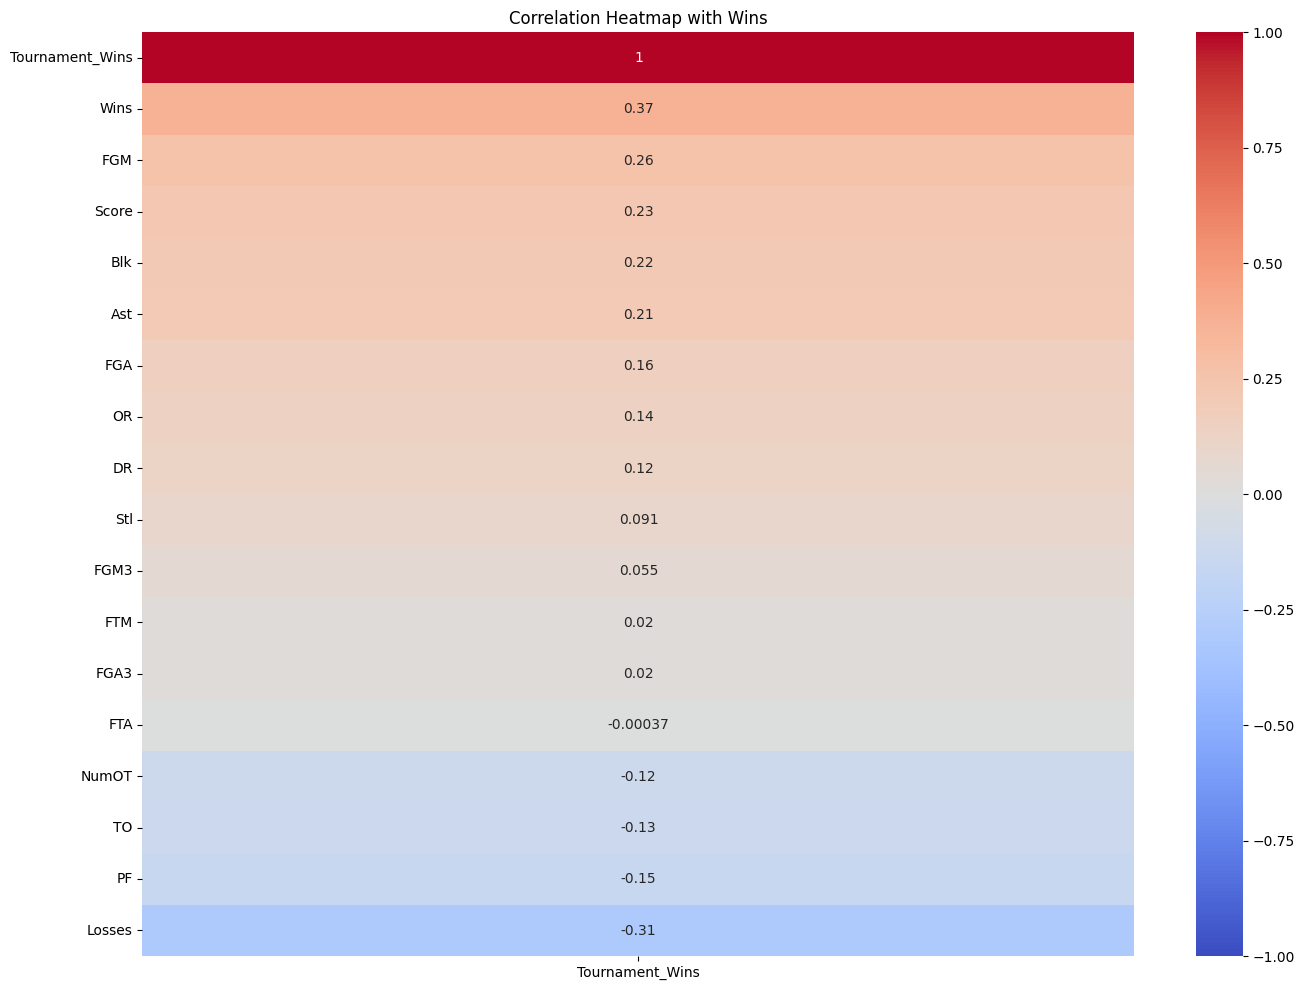

In [4]:
def show_correlation(df,features,target='Wins'):
    correlation_matrix = df[list(set(features+[target]))].corr()
    corr_with_target=correlation_matrix[[target]].sort_values(by=target, ascending=False)
    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(16, 12))  # Adjust the figure size as needed
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap with Wins')
    plt.show()
    return corr_with_target
def fit_baseline_model(df,features):
    """Regressor that predicts Tournament Wins"""
    target = 'Tournament_Wins'
    
    #features=['Wins']
    # Time-based split (assuming 'Season' represents time)
    seasons = sorted(df['Season'].unique())
    train_seasons = seasons[:int(len(seasons) * 0.8)]
    test_seasons = seasons[int(len(seasons) * 0.8):]
    
    # Create train and test DataFrames
    train = df[df['Season'].isin(train_seasons)]
    test = df[df['Season'].isin(test_seasons)]
    
    # Create feature matrices
    X_train = train[features]
    X_test = test[features]
    y_train = train[target]
    y_test = test[target]
    
    # XGBoost Model
    xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression task
    n_estimators=300,
    learning_rate=0.1,
    gamma=0.2,
    max_depth=3,
    subsample=0.8,
    random_state=42
    )
    
    # Train the model
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xgb_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test Mean Squared Error: {mse}")
    print(f"Test R2 score: {r2}")
    
    # If you want to evaluate on the training data as well.
    y_train_pred = xgb_model.predict(X_train)
    r2_train=r2_score(y_train,y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    print(f"Training Mean Squared Error: {train_mse}")
    print(f'Train R2 Score {r2_train}')
rs_team_stats_men_dummied=pd.get_dummies(rs_team_stats_men, columns=['ConfAbbrev'])
features = [col for col in rs_team_stats_men_dummied.columns if col not in ['Season', 'TeamID', 'ConfAbbrev', 'Tournament_Wins']]
fit_baseline_model(filter_tournament_teams(rs_team_stats_men_dummied),features)

features = [col for col in rs_team_stats_men.columns if col not in ['Season', 'TeamID', 'ConfAbbrev', 'Tournament_Wins']]
corr_with_target_tournament_wins=show_correlation(filter_tournament_teams(rs_team_stats_men),features,target='Tournament_Wins')

**Original Model Summary:**
* **Test Performance:** Poor performance on the test set.  None of the target is explained by the features.
* **Overfitting:** Extreme difference between the R2 on the training set and the rest set.

# Create Conference Difference Features
- For each statistic calculate the difference between the teams average and the conferences average

Test Mean Squared Error: 1.4757374381725645
Test R2 score: 0.15053032801944788
Training Mean Squared Error: 0.23325517069390375
Train R2 Score 0.8671223382315036


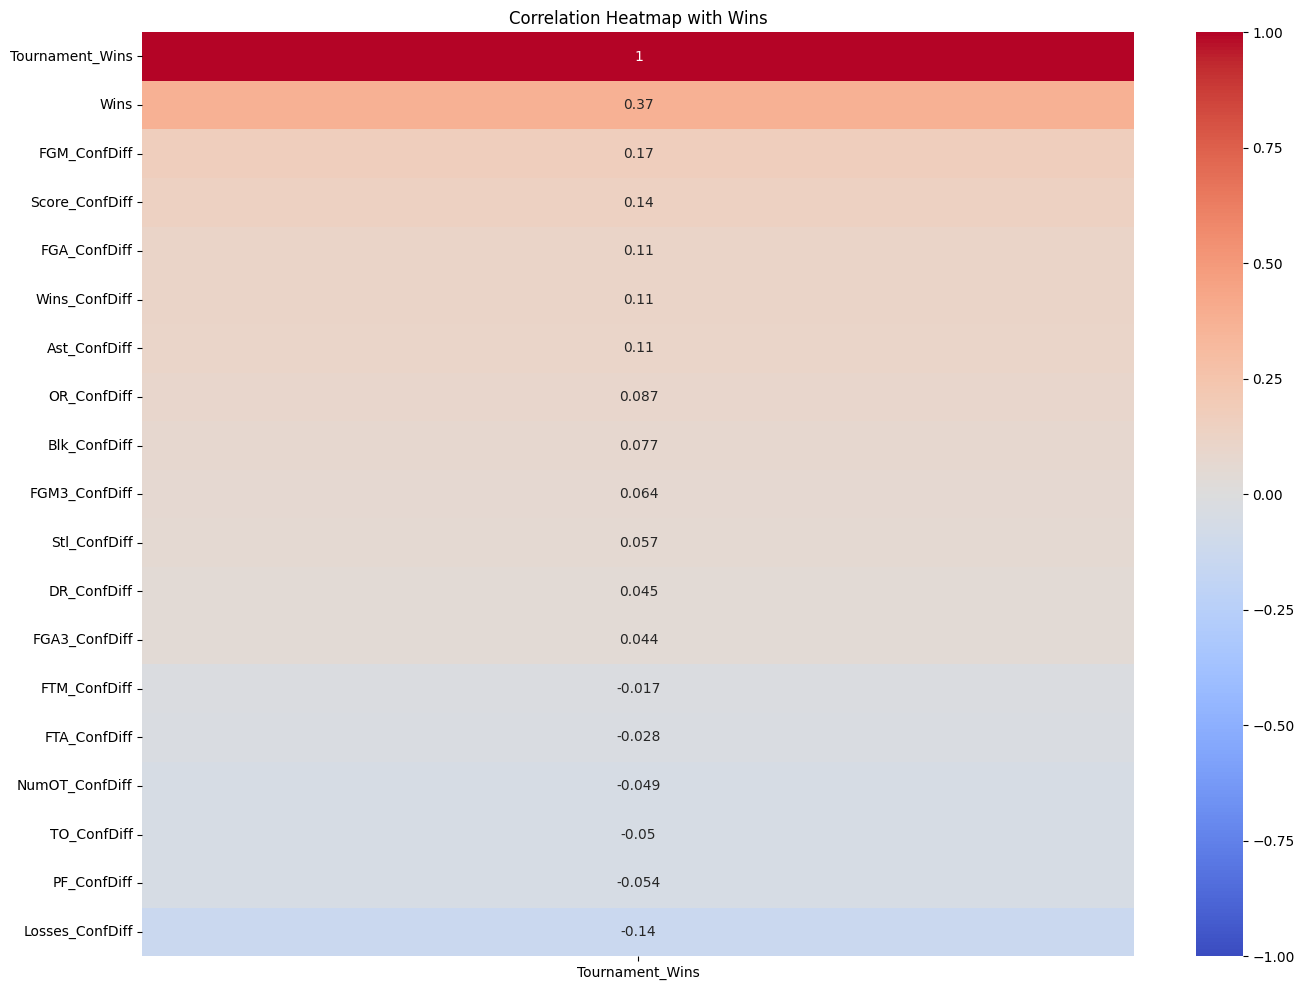

In [5]:
# Select features for conference-level aggregation
features = [col for col in rs_team_stats_men.columns if col not in ['Season', 'TeamID', 'ConfAbbrev', 'Tournament_Wins']]

# Create an aggregation dictionary for mean values of selected features
agg_dict = {col: 'mean' for col in features}

# Calculate mean conference statistics for each season
conference_stats = rs_team_stats_men.groupby(['ConfAbbrev', 'Season']).agg(agg_dict).reset_index()

# Rename the aggregated conference columns
conference_stats.rename(columns={col: f'{col}_Conference' for col in features}, inplace=True)

# Merge the conference statistics back into the team-level statistics DataFrame
rs_team_stats_men_conf = pd.merge(rs_team_stats_men, conference_stats, on=['ConfAbbrev', 'Season'])

# Create columns for the difference between team stats and conference stats
conf_diff_cols = [f'{col}_ConfDiff' for col in features]
original_cols = [col for col in features]
conference_cols = [f'{col}_Conference' for col in features]

# Calculate the difference and store it in new columns
rs_team_stats_men_conf[conf_diff_cols] = rs_team_stats_men_conf[original_cols].values - rs_team_stats_men_conf[conference_cols].values

# Select features for the baseline model (difference columns and 'Wins')
features = [col for col in rs_team_stats_men_conf.columns if 'Diff' in col] + ['Wins']

# Fit and evaluate the baseline model using the selected features
fit_baseline_model(filter_tournament_teams(rs_team_stats_men_conf), features)

# Calculate and display the correlation between features and the target variable ('Tournament_Wins')
corr = show_correlation(filter_tournament_teams(rs_team_stats_men_conf), features, target='Tournament_Wins')

**Conference Features Addition Summary:**
* **Test Performance:** Improved slightly compared to the original model, but still relatively poor. A small portion of the target variance is now explained by the features.
* **Overfitting:** Still significant, with a large gap between training and test R2 scores, though slightly reduced from the original.
* **Overall:** Conference features added some predictive power, but the model remains significantly overfit and unreliable.

# Add Average Ranking features
- For each team and season calculate the average ranking over the entire season, using all ranking systems.

Test Mean Squared Error: 1.3151859195145592
Test R2 score: 0.24294761199055992
Training Mean Squared Error: 0.20433611222216577
Train R2 Score 0.8835965576832716


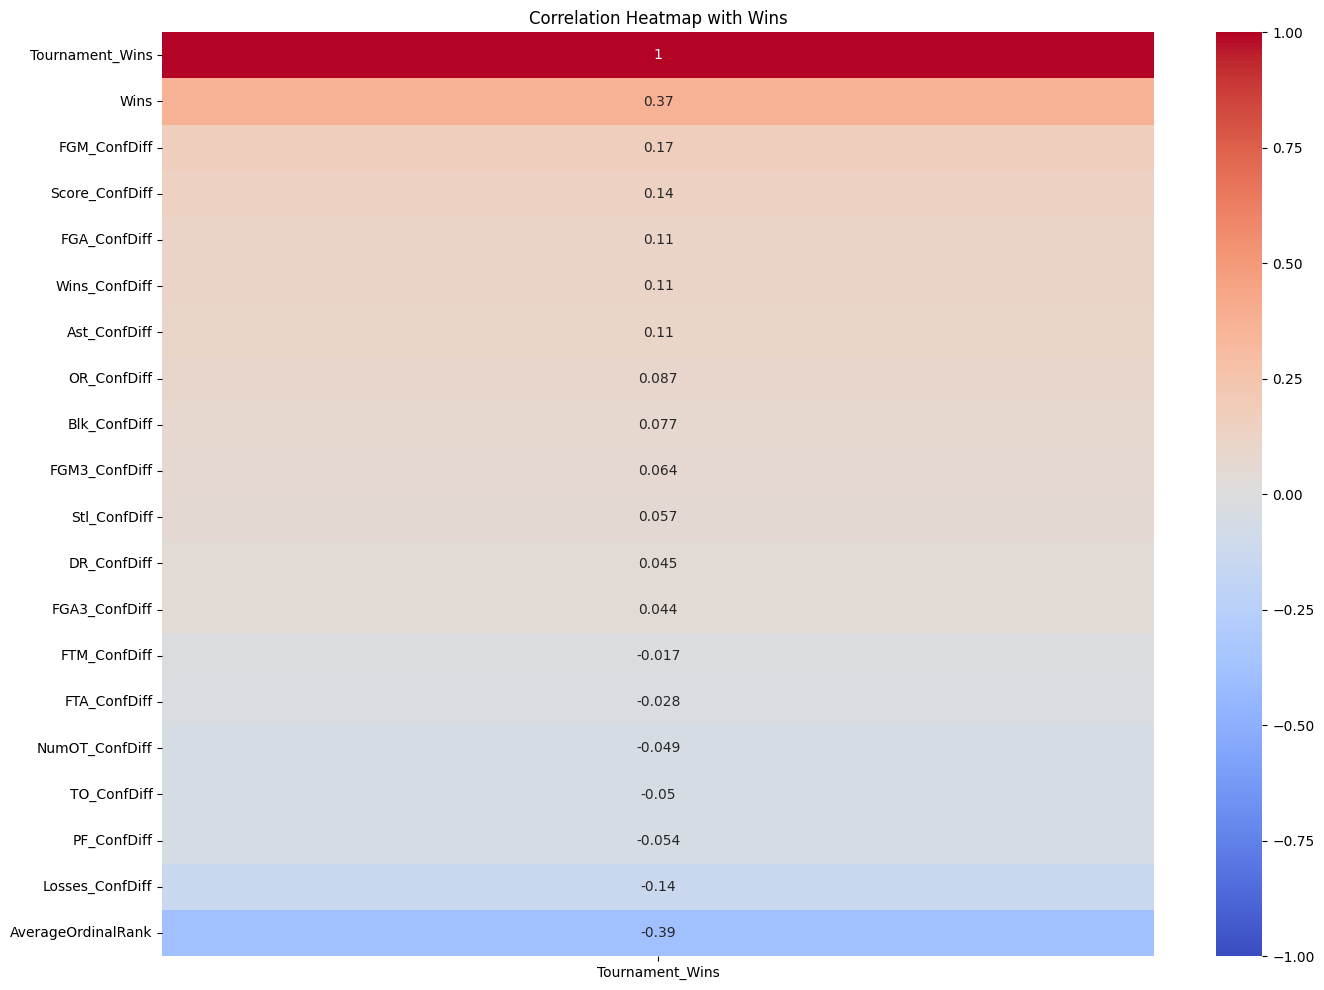

In [6]:
# Load rankings DataFrame for men
rankings = data_dict['MMasseyOrdinals']

# Calculate the average ranking for each team in each season
average_rankings = rankings.groupby(['Season', 'TeamID'])['OrdinalRank'].mean().reset_index()

# Rename the 'OrdinalRank' column to 'AverageOrdinalRank'
average_rankings.rename(columns={'OrdinalRank': 'AverageOrdinalRank'}, inplace=True)

rs_team_stats_men_conf_rank=pd.merge(rs_team_stats_men_conf,average_rankings,on=['Season','TeamID'])

features=[col for col in rs_team_stats_men_conf.columns if 'Diff' in col]+['Wins']+['AverageOrdinalRank'] # Add new features
fit_baseline_model(filter_tournament_teams(rs_team_stats_men_conf_rank),features) # Fit and evaluate xgb model
corr=show_correlation(filter_tournament_teams(rs_team_stats_men_conf_rank),features,target='Tournament_Wins') # Show correlation


**Average Ordinal Rank Feature Addition Summary:**

* **Improved Predictability:** Test R2 increased, indicating improved predictive power of the model on unseen data.
* **Moderate Correlation:** Average ordinal rank shows a moderate negative correlation (-0.39) with the target, suggesting that better (lower) rankings are associated with higher target values.
* **Reduced Overfitting (Slightly):** The gap between training and test R2 has slightly decreased, indicating a small improvement in generalization.
* **Feature Contribution:** Average ordinal rank contributes to a more predictive model, but overfitting remains a concern.

# Add Latest Ranking Feature
- Add a feature for the latest ranking for one of the ranking systems.
- In this case I chose POM as the ranking system to use

Test Mean Squared Error: 1.2675963024598702
Test R2 score: 0.2703413307805277
Training Mean Squared Error: 0.18225130522758598
Train R2 Score 0.8961775328673085


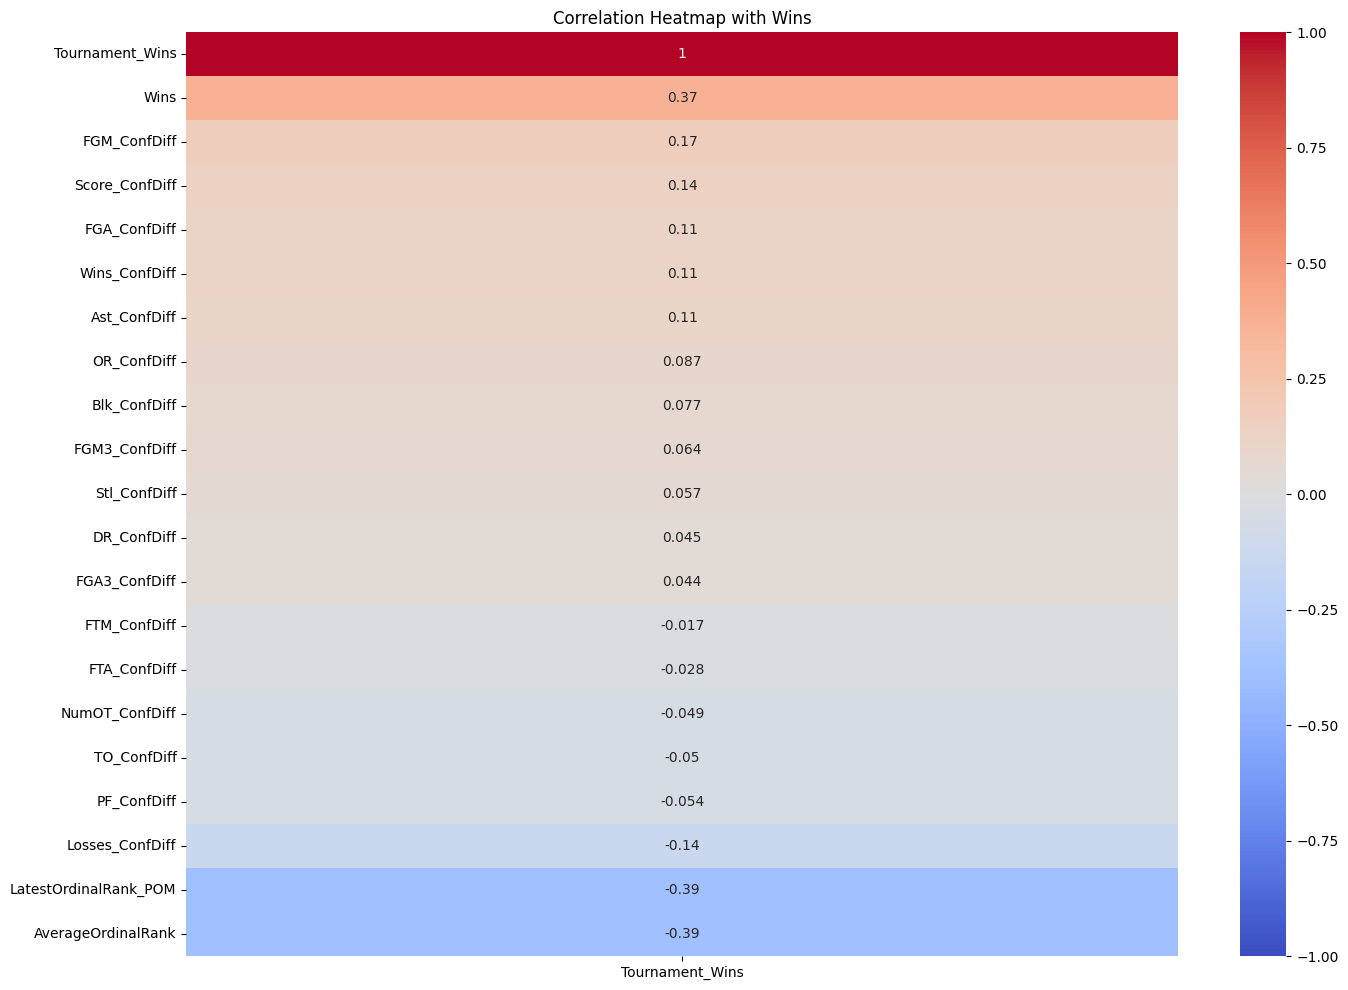

In [7]:
rankings = data_dict['MMasseyOrdinals']
# Choose a ranking system (e.g., 'POM', 'SAG', 'WOL')
selected_system = 'POM'  # Use the POM ranking system

# Filter for the selected system
filtered_rankings = rankings[rankings['SystemName'] == selected_system]

# Sort by RankingDayNum
sorted_rankings = filtered_rankings.sort_values('RankingDayNum', ascending=False)

# Get the latest ranking for each team-season
latest_rankings = sorted_rankings.groupby(['Season', 'TeamID']).first().reset_index()

# Rename the 'OrdinalRank' column to 'LatestOrdinalRank'
latest_rankings.rename(columns={'OrdinalRank': 'LatestOrdinalRank_POM'}, inplace=True)


rs_team_stats_men_conf_rank=pd.merge(filter_tournament_teams(rs_team_stats_men_conf_rank),latest_rankings,on=['Season','TeamID'])

features=[col for col in rs_team_stats_men_conf.columns if 'Diff' in col]+['Wins']+['AverageOrdinalRank']+['LatestOrdinalRank_POM']
fit_baseline_model(rs_team_stats_men_conf_rank,features)

corr=show_correlation(filter_tournament_teams(rs_team_stats_men_conf_rank),features,target='Tournament_Wins')

**Latest POM Ordinal Rank Feature Addition Summary:**

* **Improved Predictability:** Further increase in Test R2, indicating improved predictive power on unseen data.
* **Correlation:** correlation of -0.39 indicates a weak to moderate negative relationship.

# Add Momentum
- Add a feature that may capture momentum of a team as the tournament approaches.
- Take the spearman correlation coefficient between the POM Ordinal Rank and the 'RankingDayNum'.  Positive values will represent increasing momentum towards the end of the year.

Test Mean Squared Error: 1.2837650273492405
Test R2 score: 0.26103422704185375
Training Mean Squared Error: 0.19080288740058124
Train R2 Score 0.8913059827953921


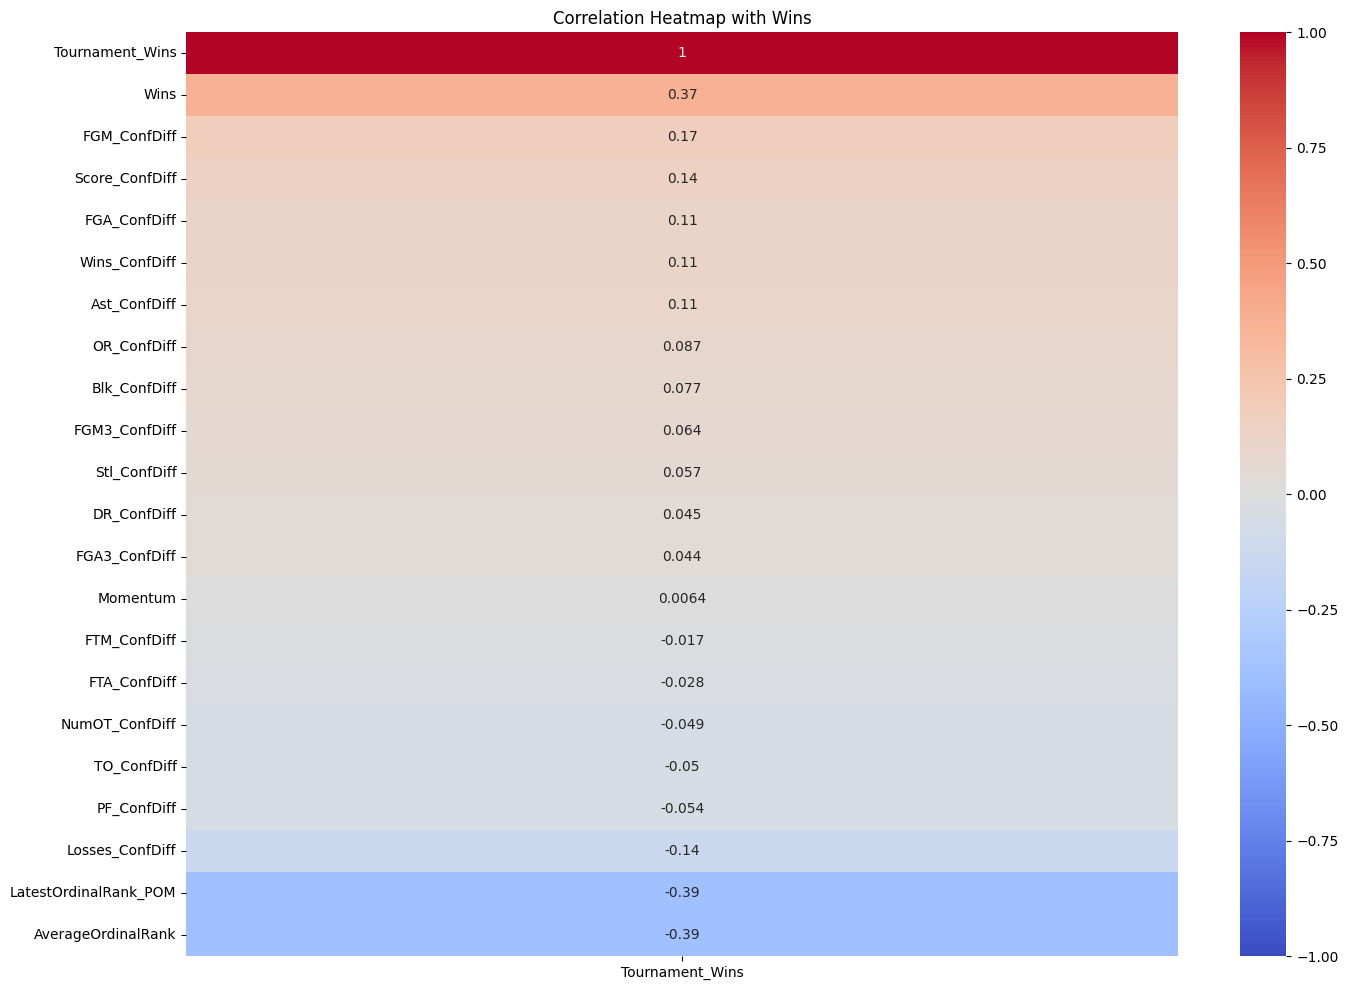

In [8]:
def calculate_momentum(group):
    """Calculates Spearman correlation coefficient for momentum."""

    group = group.sort_values('RankingDayNum', ascending=False)
    last_40 = group.head(40)

    if len(last_40) < 2:  # Need at least 2 data points for correlation
        return 0  # Or any other suitable default

    return spearmanr(last_40['RankingDayNum'], last_40['OrdinalRank']).correlation

# Merge the filtered rankings from previous cell (POM rankings) with the existing data
with_rankings=pd.merge(rs_team_stats_men_conf,filtered_rankings,on=['Season','TeamID'])
# Assuming with_rankings and filtered_rankings are your DataFrames
with_rankings = pd.merge(rs_team_stats_men_conf, filtered_rankings, on=['Season', 'TeamID'])

# Calculate momentum for each team-season
momentum = with_rankings.groupby(['Season', 'TeamID']).apply(calculate_momentum).reset_index(name='Momentum')

# Merge momentum into with_rankings
data_with_momentum = pd.merge(rs_team_stats_men_conf_rank, momentum, on=['Season', 'TeamID'])

features=[col for col in data_with_momentum.columns if 'Diff' in col]+['Wins']+['AverageOrdinalRank']+['LatestOrdinalRank_POM']+['Momentum']
fit_baseline_model(filter_tournament_teams(data_with_momentum),features)
corr=show_correlation(filter_tournament_teams(data_with_momentum),features,target='Tournament_Wins')

**Momentum Feature Addition Summary:**

* **Minimal Impact on Predictability:** Test R2 shows negligible change, indicating the momentum feature adds little to no predictive power.
* **Near-Zero Correlation:** The momentum feature exhibits almost zero correlation with the target, confirming its lack of predictive value.

# Add tournament seeds to data
- Add a column that represents the teams region
- Add a column that represents whether the team was in the first four part of the tournament.
- Add a column for the seed

In [9]:
def extract_seed_number(seed_str):
    """
    Extracts the numeric seed value from a string, removing 'a' or 'b' suffixes.

    Args:
        seed_str (str): The seed string (e.g., 'Z01', 'W16a', 'Not In Tournament').

    Returns:
        float or str: The numeric seed value as a float, or 'Not In Tournament' if applicable.
    """

    if seed_str == 'ot In Tournament':
        return 'Not In Tournament'

    # Remove 'a' or 'b' suffix if present
    seed_str = re.sub(r'[ab]$', '', seed_str)

    match = re.search(r'^\d+', seed_str)  # Look for digits at the start
    if match:
        return float(match.group(0))  # Convert to float directly
    else:
        print(f"Unexpected seed string: {seed_str}")
        return 17.0  # Default value for seeds that don't match (for consistency)

# Mens seed data for the tournament
tourney_seeds = data_dict['MNCAATourneySeeds']
# Merge with existing data
with_tourney_seeds = pd.merge(data_with_momentum, tourney_seeds, on=['Season', 'TeamID'], how='left')

# Add column for seed
with_tourney_seeds['Seed'] = with_tourney_seeds['Seed'].fillna('Not In Tournament')

# Add column for region
with_tourney_seeds['Region'] = with_tourney_seeds['Seed'].str[0]

# Add column for first four (in the first four games or not)
with_tourney_seeds['First_Four'] = with_tourney_seeds['Seed'].str.contains(r'[ab]$', regex=True).astype(int)
with_tourney_seeds['Seed'] = with_tourney_seeds['Seed'].str[1:].apply(extract_seed_number)
with_tourney_seeds['Seed'].value_counts()

Seed
16.0    118
11.0    102
12.0     88
13.0     85
14.0     85
10.0     85
8.0      84
1.0      84
5.0      84
6.0      84
3.0      84
4.0      84
15.0     84
2.0      84
9.0      84
7.0      84
Name: count, dtype: int64

# Add Inner region Statistics and Differences
- For each stat calculate the difference between the team and its region.
- Teams play teams in there region more frequently in the NCAA tournament, so calculating these differences could increase predictability.


Test Mean Squared Error: 1.3469779445375636
Test R2 score: 0.22464736401329677
Training Mean Squared Error: 0.1344387219547642
Train R2 Score 0.9234147608760342


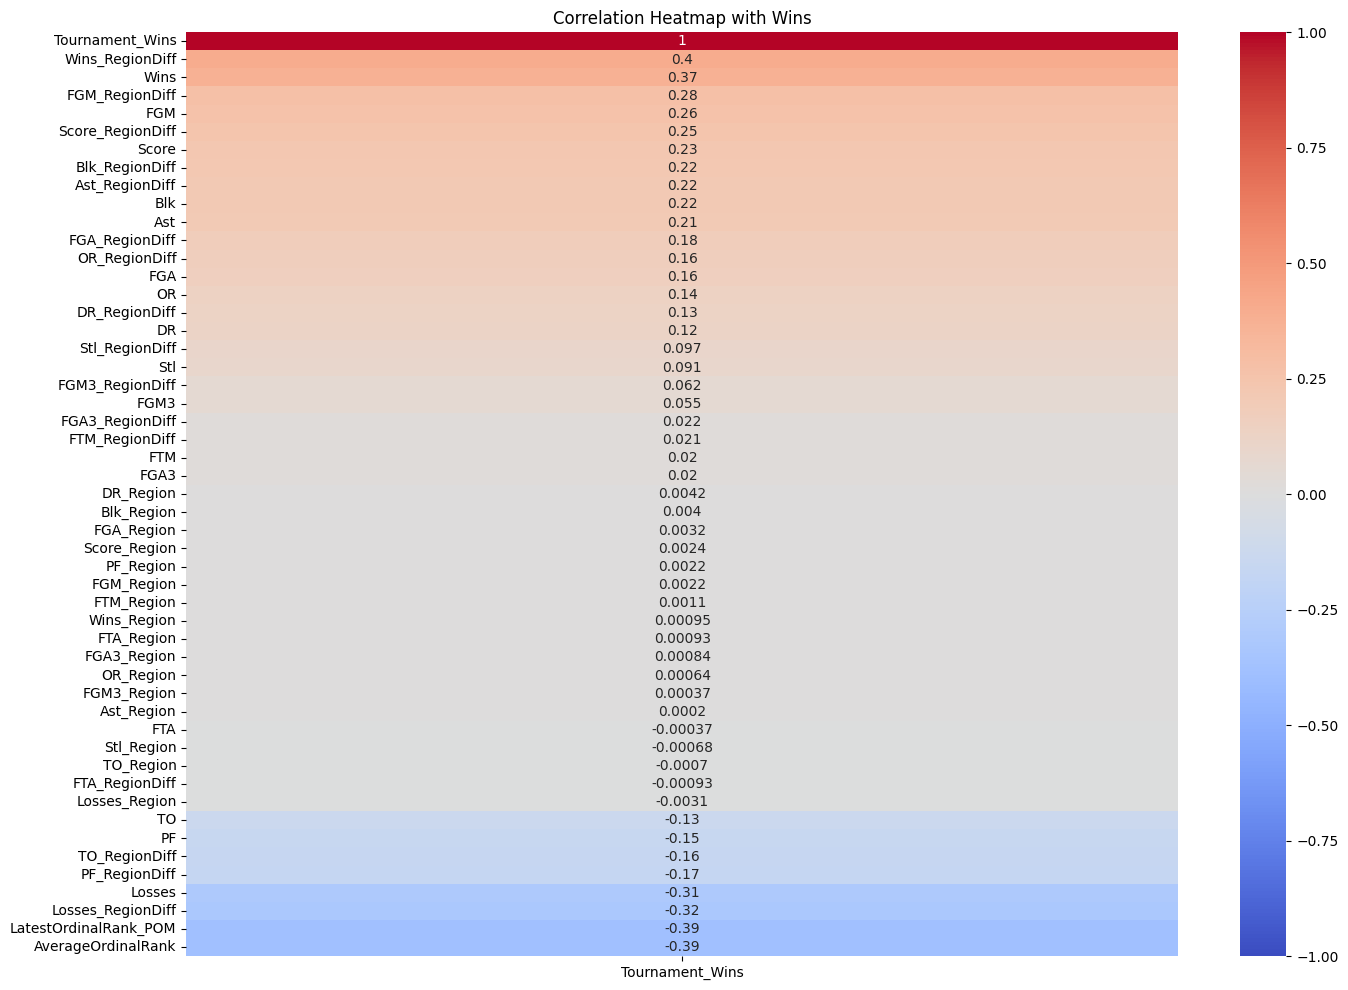

In [10]:
# Select features for region-level aggregation, excluding specific columns
features = [col for col in rs_team_stats_men.columns if col not in ['Season', 'TeamID', 'ConfAbbrev', 'Tournament_Wins', 'NumOT']]

# Create an aggregation dictionary for mean values of selected features
agg_dict = {col: 'mean' for col in features}

# Calculate mean region statistics for each season
region_stats = with_tourney_seeds.groupby(['Region', 'Season']).agg(agg_dict).reset_index()

# Rename the aggregated region columns
region_stats.rename(columns={col: f'{col}_Region' for col in features}, inplace=True)

# Merge the region statistics back into the team-level statistics DataFrame
with_tourney_seeds = pd.merge(with_tourney_seeds, region_stats, on=['Region', 'Season'])

# Create columns for the difference between team stats and region stats
region_diff_cols = [f'{col}_RegionDiff' for col in features]
original_cols = [col for col in features]
region_cols = [f'{col}_Region' for col in features]


# Calculate the difference and store it in new columns
with_tourney_seeds[region_diff_cols] = with_tourney_seeds[original_cols].values - with_tourney_seeds[region_cols].values

tournament_only=with_tourney_seeds[with_tourney_seeds['Seed']!='Not In Tournament']

# Select features for correlation analysis and baseline model fitting
features = original_cols + region_cols +region_diff_cols+ [col for col in with_tourney_seeds.columns if 'OrdinalRank' in col] 

# Fit and evaluate the baseline model using the selected features
fit_baseline_model(filter_tournament_teams(with_tourney_seeds), features)

# Calculate and display the correlation matrix between features and the target variable ('Tournament_Wins')
corr_matrix = show_correlation(filter_tournament_teams(with_tourney_seeds), features, target='Tournament_Wins')

**Regional Features and Differences Addition Summary (Corrected):**

* **Decreased Predictability (Slightly):** Test R2 decreased slightly, indicating a minor reduction in predictive power on unseen data.
* **Increased Overfitting:** Significant increase in the gap between training and test R2, suggesting a worsening of overfitting.
* **Feature Contribution:** Regional features and their differences appear to add noise or complexity, negatively impacting model generalization.
* **Correlation:** Some of the regional differences have a moderate correlation with the target.
* **Overall:** Regional data degrades model performance and exacerbates overfitting.

## Feature Analysis: Impact on Tournament Wins Prediction

**Key Findings:**

* **Significant Improvement in Predictive Power:**
    * The engineered regional difference and ranking features demonstrably enhance the predictability of tournament wins. This is evidenced by the substantial increase in the Test R² score, moving from near-zero to approximately 0.20-0.27. This improvement underscores the value of capturing relative performance within regional contexts.
* **Enhanced Predictive Strength of Regional Differences:**
    * A consistent trend emerges: regional difference features exhibit stronger correlations with `Tournament_Wins` compared to their corresponding raw statistical counterparts.
        * For example:
            * `Wins_RegionDiff` (0.403) vs. `Wins` (0.372)
            * `FGM_RegionDiff` (0.281) vs `FGM` (0.261)
            * `Score_RegionDiff` (0.246) vs `Score` (0.229)
    * This suggests that relative performance within a region is a more potent indicator of tournament success than absolute performance metrics.
* **Dominant Predictive Influence of Ranking Features:**
    * The ordinal ranking features, `AverageOrdinalRank` (-0.390) and `LatestOrdinalRank_POM` (-0.386), emerge as the most powerful predictors of `Tournament_Wins`. Their strong negative correlations indicate that teams with lower (better) ordinal rankings tend to achieve more tournament wins. This aligns with the intuitive understanding that higher-ranked teams are more likely to succeed in tournaments.
* **Informative Statistical Correlations:**
    * Positive correlations between `Tournament_Wins` and features like `FGM`, `Score`, `Blk`, `Ast`, `OR`, and `DR` (and their regional differences) highlight the importance of fundamental basketball statistics in predicting tournament success.
    * Conversely, negative correlations with `Losses`, `PF`, and `TO` (and their regional differences) reinforce the detrimental impact of these factors on tournament performance.
* **Limited Predictive Value of Regional-Only Features:**
    * Features representing purely regional statistics (e.g., `DR_Region`, `Blk_Region`) exhibit near-zero correlations with `Tournament_Wins`. This indicates that regional statistics, when considered in isolation, offer minimal predictive insight.
* **Potential for Robust Predictive Modeling:**
    * The observed correlations and the substantial improvement in R² suggest that the engineered features, particularly regional differences and ranking metrics, hold significant potential for constructing a robust predictive model for tournament game outcomes.

**In summary:** The strategic creation of regional difference features, combined with the strong predictive power of ordinal rankings, has significantly enhanced the ability to predict tournament wins. This analysis provides a solid foundation for developing accurate and reliable predictive models.

**Next Steps:**

* The next critical step involves generating difference columns between the team's features and those of their actual opponents.
* Subsequently, a classification model should be developed to predict the outcomes of individual tournament games, leveraging these newly engineered features.

# Create Tournament Data Prepared for Survival Analysis or Classification
- Combines regular season data with tournament game data
- Creates event target efs (represents a loss) and event time target (DayNum).  This is suitable for survival analysis or classification.
- Creates difference metrics between the team and the opposing team.

In [11]:
# Tournament Results
tournament_results=data_dict['MNCAATourneyDetailedResults']

# Create Game_ID column
tournament_results['Game_ID']=tournament_results.index

# Creat DataFrame with only the winning team stats.
winning_teams=tournament_results[['Game_ID','Season','DayNum','LTeamID']+[col for col in tournament_results.columns if col.startswith('W')]]

# Rename the tournament game stats with prefix 'Game_' to avoid duplicate column names
first_columns=['Game_ID','Season','DayNum','LTeamID','WTeamID'] # Keep LTeamID to merge later
winning_teams.columns=first_columns+[re.sub('W','Game_',col) for col in winning_teams.columns if col not in first_columns]

# Merge the winning team stats with the regular season data
rename_dict_rs={col:f'Reg_{col}' for col in with_tourney_seeds.columns if col not in ['Season','WTeamID','LTeamID','DayNum','TeamID']}
all_tournament_data_win=pd.merge(winning_teams,with_tourney_seeds.rename(columns=rename_dict_rs), left_on=['Season','WTeamID'],right_on=['Season','TeamID'])

# Create DataFrame that holds the losing team stats
losing_teams=tournament_results[['Game_ID','Season','DayNum','WTeamID']+[col for col in tournament_results.columns if col.startswith('L')]]
losing_teams_copy=losing_teams.copy()

# Rename game data for the losing team using prefix 'Game_' to avoid duplicate column names
first_columns = ['Game_ID', 'Season', 'DayNum', 'WTeamID', 'LTeamID'] #
losing_teams.columns=first_columns+[re.sub('L','Game_',col) for col in losing_teams.columns if col not in first_columns]
rename_dict_rs={col:f'Reg_{col}' for col in with_tourney_seeds.columns if col not in ['Season','WTeamID','LTeamID','DayNum','TeamID','Game_ID']}

# Merge the losing team data with its regular season data.
all_tournament_data_lose=pd.merge(losing_teams,with_tourney_seeds.rename(columns=rename_dict_rs), left_on=['Season','LTeamID'],right_on=['Season','TeamID'])
losing_idx=tournament_results['LTeamID'].values

# Set TeamID to the ID of the winning team and the Opponent_TeamID to the losing team for the winning team DataFrame
all_tournament_data_win['TeamID']=all_tournament_data_win['WTeamID']
all_tournament_data_win['Opponent_TeamID']=all_tournament_data_win['LTeamID']

# Set the efs=0 for the winning team.  efs=0 will represent winning.
all_tournament_data_win['efs']=0

# Rename the regular season data with prefix 'Opponent_' with the intent of merging to with the winning team data.
rename_dict_rs={col:f'Opponent_reg_{col}' for col in with_tourney_seeds.columns if col not in ['Season','WTeamID','LTeamID','DayNum','TeamID','Game_ID']}
to_join=with_tourney_seeds.rename(columns=rename_dict_rs)

# Merge the Opponent data with the winning team data
all_tournament_data_win_opponent=pd.merge(all_tournament_data_win,to_join,left_on=['Season','LTeamID'],right_on=['Season','TeamID'])

# Drop the WTeamID column and the LTeamID which are now TeamID and Opponent_TeamID respectively
all_tournament_data_win_opponent.drop(columns=['WTeamID','LTeamID'],inplace=True)

# In the losing team data make TeamID=LTeamID
all_tournament_data_lose['TeamID']=all_tournament_data_lose['LTeamID']
# Make the OpponentID = WTeamID
all_tournament_data_lose['Opponent_TeamID']=all_tournament_data_lose['WTeamID']
# Make all the rows efs=1, meaning the TeamID lost the game
all_tournament_data_lose['efs']=1

# Merge the winning team data with the losing team id with the feature names having prefix 'Opponent_'
all_tournament_data_lose_opponent=pd.merge(all_tournament_data_lose,to_join,left_on=['Season','WTeamID'],right_on=['Season','TeamID'])

# Drop WTeamID and LTeamID which are now Opponent_TeamID and TeamID respectively
all_tournament_data_lose_opponent.drop(columns=['WTeamID','LTeamID'],inplace=True)

# Concatenate the winning team data and the losing team data
all_tournament_data_survival=pd.concat([all_tournament_data_win_opponent,all_tournament_data_lose_opponent])

# Create a time passes column called 'efs_time' which will represent the depth into the tournament.
all_tournament_data_survival['efs_time']=all_tournament_data_survival['DayNum']-all_tournament_data_survival['DayNum'].min() 
all_tournament_data_survival=all_tournament_data_survival.drop(columns=['TeamID_y']).rename(columns={'TeamID_x':'TeamID'})

# Create Opponent Difference Features
- For each stat calculate the difference between the team and the opponent.

In [12]:

# List of regular season features (excluding opponent features)
reg_features = [
    'Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
    'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Wins', 'Losses',
     'Seed', 'AverageOrdinalRank', 'LatestOrdinalRank_POM',
    'Momentum']

# Calculate regular season differences (team - opponent)
for col in reg_features:
    all_tournament_data_survival[f'{col}_Diff'] = \
        all_tournament_data_survival[f'Reg_{col}'] - all_tournament_data_survival[f'Opponent_reg_{col}']

# Display the first few rows with the new difference columns
all_tournament_data_survival.head()

,Game_ID,Season,DayNum,Game_Score,Game_Loc,Game_FGM,Game_FGA,Game_FGM3,Game_FGA3,Game_FTM,...,TO_Diff,Stl_Diff,Blk_Diff,PF_Diff,Wins_Diff,Losses_Diff,Seed_Diff,AverageOrdinalRank_Diff,LatestOrdinalRank_POM_Diff,Momentum_Diff
0,0,2003,134,92,N,32,69,11,29,17,...,0.973563,0.635632,0.766667,0.803448,-5,4.0,0.0,5.152500,5,0.975259
1,1,2003,136,80,N,31,66,7,23,11,...,0.716749,1.602217,1.248768,1.853448,6,-7.0,-15.0,-168.120756,-141,-0.718663
2,2,2003,136,84,N,31,59,6,14,16,...,0.206897,-2.172414,-0.827586,0.655172,-5,5.0,3.0,-1.107500,12,-0.433349
3,3,2003,136,79,N,29,53,3,7,18,...,4.877743,-1.290491,-0.454545,3.692790,-6,2.0,5.0,58.225233,23,-1.839866
4,4,2003,136,76,N,27,64,7,20,15,...,-0.027586,-1.214943,-0.273563,-1.563218,3,-4.0,-1.0,-14.703429,-8,-1.110914


### XGB Survival Model
- Split using train_test_split

In [13]:
def preprocess_train_test_split(df, test_size=0.15, random_state=42, stratify='efs'):
    train, test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[stratify])
    return train, test
def preprocess_time_split(df, test_season=2024):
    train = df[df['Season'] < test_season]
    test = df[df['Season'] == test_season]
    return train, test


def fit_xg_survival_model(train, test, features, subsample=0.8, max_depth=4, learning_rate=0.3, n_estimators=300,show_importance=True):
    """
    Fits a Gradient Boosting Survival Analysis model.

    Args:
        train (pd.DataFrame): Training DataFrame.
        test (pd.DataFrame): Test DataFrame.
        features (list): List of feature column names.
        filename (str): Filename for saving the model.
        subsample (float): Subsample ratio for gradient boosting.
        max_depth (int): Maximum depth of the trees.
        learning_rate (float): Learning rate for gradient boosting.
        n_estimators (int): Number of boosting iterations.

    Returns:
        tuple: (fitted model, test DataFrame with risk scores)
    """

    # Prepare feature matrices
    X_train = train[features]
    X_test = test[features]

    # Prepare target variables (survival format)
    y_train = train[['efs', 'efs_time']].to_records(index=False)
    y_train = np.array([(bool(e), t) for e, t in y_train], dtype=[('efs', bool), ('efs_time', float)])

    y_test = test[['efs', 'efs_time']].to_records(index=False)
    y_test = np.array([(bool(e), t) for e, t in y_test], dtype=[('efs', bool), ('efs_time', float)])

    # Initialize and fit the model
    gb_model = GradientBoostingSurvivalAnalysis(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=42
    )
    gb_model.fit(X_train, y_train)

    # Evaluate the model
    c_index = gb_model.score(X_test, y_test)
    print(f"Concordance Index: {c_index:.3f}")

    # Predict risk scores
    risk_scores = gb_model.predict(X_test)

    # Print feature importances
    if show_importance:
        for feature, importance in zip(features, gb_model.feature_importances_):
            print(f"{feature}: {importance:.4f}")

    # Add risk scores to the test DataFrame
    test['risk_scores'] = risk_scores

    return gb_model, test,risk_scores
features=[col for col in all_tournament_data_survival.columns if 'Diff' in col]
features=[col for col in features if 'Conf' not in col]
features=list(set(features+[col for col in all_tournament_data_survival.columns if 'Ordinal' in col]))
features=features+['Reg_Wins','Reg_Score']
train, test_survival=preprocess_train_test_split(all_tournament_data_survival)
gb_model,test,risk_scores=fit_xg_survival_model(train, test_survival, features)

Concordance Index: 0.861
Opponent_reg_DR_RegionDiff: 0.0101
Blk_Diff: 0.0117
Reg_OR_RegionDiff: 0.0184
Opponent_reg_Losses_RegionDiff: 0.0127
Reg_Ast_RegionDiff: 0.0288
FGM3_Diff: 0.0105
Opponent_reg_Score_RegionDiff: 0.0050
FGM_Diff: 0.0073
Opponent_reg_PF_RegionDiff: 0.0066
LatestOrdinalRank_POM_Diff: 0.0151
Reg_Losses_RegionDiff: 0.0266
Ast_Diff: 0.0108
Reg_PF_RegionDiff: 0.0264
Momentum_Diff: 0.0138
Opponent_reg_FGM_RegionDiff: 0.0047
Reg_FGM_RegionDiff: 0.0115
Stl_Diff: 0.0106
Wins_Diff: 0.0056
Opponent_reg_OR_RegionDiff: 0.0050
Opponent_reg_FTM_RegionDiff: 0.0048
Reg_Blk_RegionDiff: 0.0276
Opponent_reg_LatestOrdinalRank_POM: 0.0177
Reg_FGA_RegionDiff: 0.0157
AverageOrdinalRank_Diff: 0.0201
FTA_Diff: 0.0095
Opponent_reg_Blk_RegionDiff: 0.0054
Reg_DR_RegionDiff: 0.0205
Reg_FGM3_RegionDiff: 0.0183
OR_Diff: 0.0104
Reg_FGA3_RegionDiff: 0.0122
TO_Diff: 0.0077
Reg_Wins_RegionDiff: 0.0316
Opponent_reg_FGM3_RegionDiff: 0.0074
Reg_Score_RegionDiff: 0.0178
FGA_Diff: 0.0075
Opponent_reg_TO_R

### XGB Classifier
- Split using train_test_split

In [14]:
def fit_xgboost_classifier(train, test, features, learning_rate=0.3, subsample=0.8, n_estimators=300, max_depth=4,show_importance=True):
    """Fits a Gradient Boosting Classifier."""

    X_train = train[features]
    y_train = train['efs']
    X_test = test[features]
    y_test = test['efs']

    xgb_model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")


    c_index = concordance_index(test['efs_time'], -y_prob,test['efs'])
    print(f"Concordance Index (using predicted probabilities): {c_index:.3f}")

    # Print feature importances
    if show_importance:
        for feature, importance in zip(features, xgb_model.feature_importances_):
            print(f"{feature}: {importance:.4f}")

    test['predicted_probability'] = y_prob

    return xgb_model, test

# Assuming all_tournament_data_survival and features are defined
train, test = preprocess_train_test_split(all_tournament_data_survival)
xgb_model, test = fit_xgboost_classifier(train, test, features)

Accuracy: 0.663
Precision: 0.668
Recall: 0.643
F1 Score: 0.655
ROC AUC: 0.732
Concordance Index (using predicted probabilities): 0.642
Opponent_reg_DR_RegionDiff: 0.0222
Blk_Diff: 0.0161
Reg_OR_RegionDiff: 0.0095
Opponent_reg_Losses_RegionDiff: 0.0074
Reg_Ast_RegionDiff: 0.0165
FGM3_Diff: 0.0136
Opponent_reg_Score_RegionDiff: 0.0125
FGM_Diff: 0.0093
Opponent_reg_PF_RegionDiff: 0.0076
LatestOrdinalRank_POM_Diff: 0.2304
Reg_Losses_RegionDiff: 0.0085
Ast_Diff: 0.0135
Reg_PF_RegionDiff: 0.0124
Momentum_Diff: 0.0183
Opponent_reg_FGM_RegionDiff: 0.0092
Reg_FGM_RegionDiff: 0.0093
Stl_Diff: 0.0176
Wins_Diff: 0.0064
Opponent_reg_OR_RegionDiff: 0.0113
Opponent_reg_FTM_RegionDiff: 0.0100
Reg_Blk_RegionDiff: 0.0156
Opponent_reg_LatestOrdinalRank_POM: 0.0143
Reg_FGA_RegionDiff: 0.0100
AverageOrdinalRank_Diff: 0.0587
FTA_Diff: 0.0058
Opponent_reg_Blk_RegionDiff: 0.0106
Reg_DR_RegionDiff: 0.0169
Reg_FGM3_RegionDiff: 0.0166
OR_Diff: 0.0112
Reg_FGA3_RegionDiff: 0.0124
TO_Diff: 0.0149
Reg_Wins_RegionDif

### Look at predictions from the survival model compared to actual results
- The hope is that the risk score for the winning team is less than the risk score of the losing team.

In [15]:
# Assign the predicted risk scores to the test_survival DataFrame.
test_survival['risk_score'] = risk_scores

# Separate winning and losing teams based on the 'efs' column (event flag).
winning_teams = test_survival[test_survival['efs'] == 0]  # efs == 0 indicates no event (win).
losing_teams = test_survival[test_survival['efs'] == 1]   # efs == 1 indicates event (loss).

# Extract relevant columns from winning teams and rename them for clarity.
games_winners = winning_teams[['TeamID', 'Season', 'Opponent_TeamID', 'DayNum', 'Game_Score', 'risk_score']].rename(
    columns={'Game_Score': 'WGame_Score', 'risk_score': 'Wrisk_score'}
)
games_winners['WTeamID'] = games_winners['TeamID'] #add team ID for later merge

# Extract relevant columns from losing teams and rename them.
games_losers = losing_teams[['TeamID', 'Season', 'Opponent_TeamID', 'DayNum', 'Game_Score', 'risk_score']].rename(
    columns={'Game_Score': 'LGame_Score', 'risk_score': 'Lrisk_score'}
)

# Merge winning and losing team data based on Season, DayNum, and Opponent_TeamID.
# This aligns each winning game with its corresponding losing game.
results = pd.merge(
    games_winners,
    games_losers,
    left_on=['Season', 'DayNum', 'Opponent_TeamID'],
    right_on=['Season', 'DayNum', 'TeamID']
)

# Determine if the prediction was correct by comparing risk scores.
# A lower risk score indicates a higher predicted probability of winning.
results['Correct_Prediction'] = results['Wrisk_score'] < results['Lrisk_score']

# Display a random sample of 15 rows to inspect the results.
results[['WGame_Score', 'LGame_Score', 'Wrisk_score', 'Lrisk_score', 'Correct_Prediction']].sample(15)

,WGame_Score,LGame_Score,Wrisk_score,Lrisk_score,Correct_Prediction
24,93,82,4.046042,6.440659,True
2,66,58,1.838966,0.960271,False
6,91,66,0.606561,-0.361915,False
22,70,48,-0.319362,0.522201,True
20,78,65,0.555855,3.182381,True
33,75,56,-0.561837,2.782783,True
28,85,69,-0.828387,0.659792,True
16,79,51,-1.990400,2.155025,True
11,75,71,5.482406,4.505310,False
19,94,88,-1.849477,-1.646178,True


### Refit with Time Split (test set 2024)
- Use the 2024 season as the test set
- Evaluate the survival model in terms of accuracy

In [16]:
# Split the tournament data into training and testing sets, where the test set is the 2024 season.
# The preprocess_time_split function ensures temporal separation for evaluation.
train, test = preprocess_time_split(all_tournament_data_survival)

# Fit the XGB Survival model to the training data and generate risk scores for the test data.
# Feature importances are not displayed (show_importance=False).
gb_model, test, risk_scores = fit_xg_survival_model(train, test, features, show_importance=False)

# Add the predicted risk scores to the test DataFrame.
test['risk_scores'] = risk_scores

# Separate winning and losing teams from the test data based on the 'efs' column.
winning_teams = test[test['efs'] == 0]  # efs == 0 indicates no event (win).
losing_teams = test[test['efs'] == 1]   # efs == 1 indicates event (loss).

# Extract relevant columns from winning teams and rename them for clarity.
games_winners = winning_teams[['TeamID', 'Season', 'Game_ID', 'DayNum', 'Game_Score', 'risk_scores']].rename(
    columns={'TeamID': 'WTeamID', 'Game_Score': 'WGame_Score', 'risk_scores': 'Wrisk_score'}
)

# Extract relevant columns from losing teams and rename them.
games_losers = losing_teams[['TeamID', 'Season', 'Game_ID', 'DayNum', 'Game_Score', 'risk_scores']].rename(
    columns={'TeamID': 'LTeamID', 'Game_Score': 'LGame_Score', 'risk_scores': 'Lrisk_score'}
)

# Merge winning and losing team data based on 'DayNum', 'Season', and 'Game_ID'.
# This aligns each winning game with its corresponding losing game.
results = pd.merge(games_winners, games_losers, on=['DayNum', 'Season', 'Game_ID'])

# Create a binary prediction column 'pred_classification' based on risk scores.
# If the winning team's risk score is lower, predict 1 (win); otherwise, predict 0 (loss).
results['pred_classification'] = (results['Wrisk_score'] < results['Lrisk_score']).astype(int)

# Create a 'y_true' column with all 1s, representing the actual win.
# In this context, 'y_true' = 1 signifies that the winning team, as defined in the data, won.
results['y_true'] = 1

# Sort the results by 'DayNum' and display the first 20 rows for inspection.
results.sort_values(by='DayNum').head(20)

# Calculate and print the accuracy of the predictions.
print('Accuracy', accuracy_score(results['y_true'], results['pred_classification']))

Concordance Index: 0.850
Accuracy 0.7164179104477612


In [17]:
def add_predicted_winner(results_df):
    """Adds a column for the predicted winner of each game."""

    predicted_winners = []
    for index, row in results_df.iterrows():
        if row['Wrisk_score'] < row['Lrisk_score']:  # Lower risk score is better
            predicted_winners.append(row['WTeamID'])
        else:
            predicted_winners.append(row['LTeamID'])

    results_df['PredictedWinner'] = predicted_winners
    return results_df
to_join=data_dict['MTeams'][['TeamID','TeamName']]
with_names=pd.merge(with_tourney_seeds,to_join,on='TeamID')
to_join=with_names[['TeamID','Region','Season','First_Four','TeamName']].rename(columns={'Region':'WRegion','TeamName':'WTeamName','First_Four':'WFirst_Four'})
results_region_win=pd.merge(results,to_join,left_on=['Season','WTeamID'],right_on=['Season','TeamID'])
to_join=with_names[['TeamID','Region','Season','First_Four','TeamName']].rename(columns={'Region':'LRegion','TeamName':'LTeamName','First_Four':'LFirst_Four'})

results_region_win_lose=pd.merge(results_region_win,to_join,left_on=['Season','LTeamID'],right_on=['Season','TeamID'])

results_region_win_lose.drop(columns=['TeamID_y','TeamID_x'],inplace=True)
results_region_win_lose = add_predicted_winner(results_region_win_lose.copy()) #Use .copy() to avoid SettingWithCopyWarning

results_region_win_lose['Correct_Prediction']=results_region_win_lose['WTeamID']==results_region_win_lose['PredictedWinner']
results_region_win_lose[['WTeamID', 'LTeamID', 'Wrisk_score', 'Lrisk_score', 'PredictedWinner','Correct_Prediction']].sample(12)

,WTeamID,LTeamID,Wrisk_score,Lrisk_score,PredictedWinner,Correct_Prediction
36,1112,1173,-2.518579,0.051952,1112,True
30,1321,1194,2.091954,0.336907,1194,False
64,1163,1104,-3.690665,-0.718409,1163,True
0,1161,1438,3.772820,4.073869,1161,True
2,1160,1129,1.218985,3.466349,1160,True
35,1463,1120,2.725278,-1.471302,1120,False
33,1401,1304,1.604470,3.040502,1401,True
47,1181,1241,-0.930516,2.063208,1181,True
18,1400,1161,1.185430,1.981810,1400,True
15,1324,1246,3.105786,0.275926,1246,False


### Compare the XBG Survival to XGB Classifier

In [18]:
train, test = preprocess_time_split(all_tournament_data_survival)
xgb_model, test = fit_xgboost_classifier(train, test, features,show_importance=False)

Accuracy: 0.687
Precision: 0.687
Recall: 0.687
F1 Score: 0.687
ROC AUC: 0.747
Concordance Index (using predicted probabilities): 0.643


# **Conclusion**

- The XGB Survival model demonstrates higher accuracy (Concordance Index: 0.84, Accuracy: 0.701) compared to the XGB Classifier ( ROC AUC: 0.749 Accuracy: 0.694) in predicting game outcomes for the 2024 season. This suggests the survival model's approach may be more effective, though thorough cross-validation is needed to confirm this.
- **The feature engineering efforts were successful in generating informative features, as evidenced by the significant feature importances in both models, particularly for regional differences and ranking metrics.** These features, derived from relative performance and team quality, contributed substantially to the models' predictive capabilities.
- Hyperparameter grid searches will be performed for both the XGB Survival model and the XGB Classifier to optimize performance and determine the most suitable model for this task. The focus will shift from accuracy to the Brier score, aligning with the competition's evaluation metric.
- Adaptations are necessary for features that rely on data beyond DayNum 121, as the 2025 dataset is limited. This includes adjusting the methodology for ranking features to accommodate the available data.